# Разработка Vision-Language Model (VLM) на основе CLIP с нуля

**Проект направлен на разработку модели, способной понимать и связывать визуальную и текстовую информацию.**

**CLIP (Contrastive Language–Image Pretraining) — это мультимодальная модель, которая связывает изображения и тексты. Она обучается на парах "изображение-текст", чтобы понимать, как они соотносятся друг с другом. CLIP может решать задачи, например, находить картинки по описанию или описывать изображения.**

**Добавим все необходимые библиотеки и загрузим датасет Flickr30k, который содержит 31,8 тыс. пар изображений и подписей.**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig
from tqdm import tqdm
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision.models as models
from torch import optim
import torch.nn.functional as F
from datasets import load_dataset

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Загрузка набора данных

In [2]:
dataset = load_dataset('nlphuji/flickr30k')

print(dataset)

DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})


**Посмотрим на загруженный датасет.**

In [3]:
train_data = dataset['test']

for data in train_data:
    print(data)
    break

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x14CFC22F050>, 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shirts are standing in a yard.', 'A man in a blue shirt standing in a garden.', 'Two friends enjoy time spent together.'], 'sentids': ['0', '1', '2', '3', '4'], 'split': 'train', 'img_id': '0', 'filename': '1000092795.jpg'}


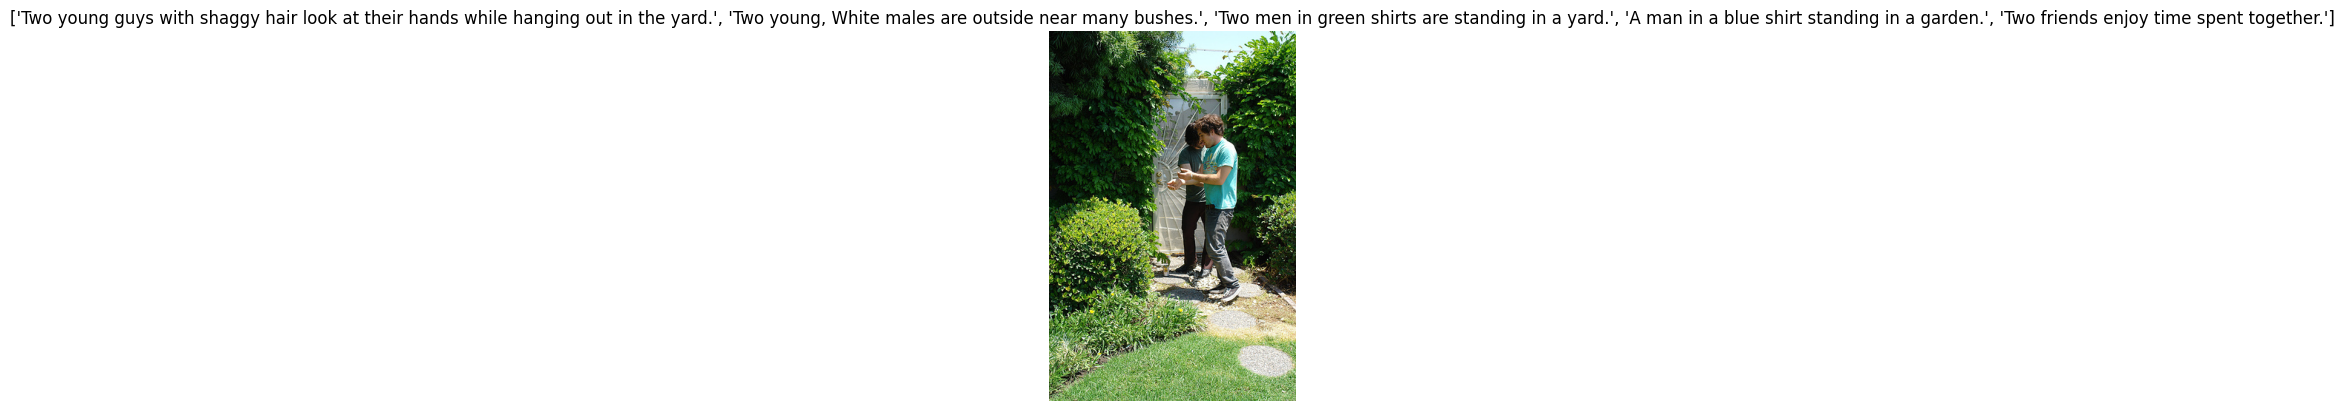

In [4]:
for data in train_data:
    image = data['image']
    caption = data['caption']
    break

plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()

### Обработка данных

**Следующий блок кода настраивает подготовку данных для обучения модели.**

**Мы будем использовать модель CLIP, которая связывает изображения и текст, и для подготовки данных создадим собственный класс CLIPDataset. Этот класс обрабатывает как изображения, так и текст. Для текста мы будем использывать токенизатор DistilBERT из библиотеки HuggingFace, чтобы преобразовать подписи в input_ids и attention_mask. Для изображений применяем преобразования, такие как изменение размера, преобразование в тензоры и нормализация. Класс также позволяет работать с фотографиями с помощью индексов.**

**В методе __getitem__ мы бдуем загружать изображение и соответствующую подпись, применять необходимые преобразования к изображению и токенизировать текст. На выходе получим кортеж, содержащий обработанное изображение, идентификаторы токенов и маску внимания. Дополнительно создадим функцию collate_fn, чтобы объединить эти элементы в батчи для обучения.**

In [5]:
class CLIPDataset(Dataset):
    def __init__(self, dataset, indices, transform=None, tokenizer=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        item = self.dataset[self.indices[idx]]
        image = item['image']  
        caption = item['caption'][0]  

        if self.transform:
            image = self.transform(image)

        if self.tokenizer:
            caption = self.tokenizer(caption, return_tensors='pt', padding='max_length', truncation=True, max_length=32)

        return image, caption['input_ids'].squeeze(0), caption['attention_mask'].squeeze(0)

In [6]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

indices = list(range(len(dataset['test'])))
train_data, val_data = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = CLIPDataset(dataset['test'], train_data, transform=image_transform, tokenizer=tokenizer)
val_dataset = CLIPDataset(dataset['test'], val_data, transform=image_transform, tokenizer=tokenizer)

def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    input_ids = torch.stack([item[1] for item in batch])
    attention_masks = torch.stack([item[2] for item in batch])
    return images, input_ids, attention_masks

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


### Image Encoder

**Теперь создадим ImageEncoder, который будет использоваться для преобразования изображений в векторные представления. В качестве основы используется предобученная модель ResNet50, из которой удалён последний классификационный слой, чтобы оставить только свёрточные слои для извлечения признаков.**

**Код кодирует каждое изображение в вектор фиксированного размера с размером выходных каналов модели (в случае ResNet50 размер вектора будет равен 2048).**

In [8]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
 
        self.cnn = nn.Sequential(
            *list(models.resnet50(pretrained=True).children())[:-1]
        )

        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)  
            dummy_output = self.cnn(dummy_input)
            self.embedding_dim = dummy_output.view(dummy_output.size(0), -1).shape[1]

    def forward(self, image):
        features = self.cnn(image)
        return features.view(features.size(0), -1)  

### Text Encoder

**Класс TextEncoder используется для преобразования текстовых данных в векторные представления. В качестве основы используется предобученная модель DistilBERT, которая является облегчённой версией BERT и сохраняет высокую производительность при меньшем количестве параметров.**

**В случае DistilBERT (а также BERT) выходное скрытое представление для каждого токена представляет собой вектор размером 768.**

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased'):
        super(TextEncoder, self).__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.config = DistilBertConfig.from_pretrained(model_name) 

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs  

### Projection Head

**После того как изображения и тексты были закодированы в векторы фиксированной размерности (2048 для изображений и 768 для текстов), необходимо привести их к общему пространству с одинаковой размерностью. Это позволит сравнивать векторы изображений и текстов, сближая соответствующие пары и отдаляя нерелевантные. Для этого используется проекционный слой (ProjectionHead), который будет преобразовывать входные векторы в пространство меньшей размерности (у нас будет — 256).**

In [10]:
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim=256, dropout=0.1):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected 
        x = self.layer_norm(x)
        return x

### CLIP

**Теперь мы будем использовать предыдущие модули, которые мы построили для реализации основной модели!**

**Функция потерь в CLIP — это контрастивная потеря, которая учит модель сближать соответствующие пары текстов и изображений и отдалять несоответствующие.** 

**Для вычисления сходства между текстовыми и визуальными эмбеддингами используется скалярное произведение, которое измеряет, насколько похожи векторы. В результате получается матрица logits, где каждый элемент отражает степень сходства между текстом и изображением. Параметр temperature масштабирует logits, что помогает контролировать процесс обучения.**

In [11]:
class CLIP(nn.Module):
    def __init__(self, text_encoder, image_encoder, projection_dim=256, dropout=0.1, temperature=0.07):
        super(CLIP, self).__init__()
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder

        text_embedding_dim = text_encoder.config.hidden_size  
        image_embedding_dim = image_encoder.embedding_dim   

        self.text_projection = ProjectionHead(text_embedding_dim, projection_dim, dropout)
        self.image_projection = ProjectionHead(image_embedding_dim, projection_dim, dropout)

        self.temperature = nn.Parameter(torch.tensor([temperature]))

    def forward(self, text_input_ids, text_attention_mask, image, labels):
        text_outputs = self.text_encoder(input_ids=text_input_ids, attention_mask=text_attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :] 
        image_features = self.image_encoder(image)

        text_embeddings = self.text_projection(text_features)
        image_embeddings = self.image_projection(image_features)

        logits_per_text = text_embeddings @ image_embeddings.T / self.temperature
        logits_per_image = image_embeddings @ text_embeddings.T / self.temperature

        loss_text = nn.CrossEntropyLoss()(logits_per_text, labels)
        loss_image = nn.CrossEntropyLoss()(logits_per_image, labels)
        loss = (loss_text + loss_image) / 2

        return loss

### Обучение

**Теперь мы готовы перейти к обучению нашей модели и оценить её результаты.**

In [12]:
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for images, input_ids, attention_mask in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = torch.arange(len(images)).to(device)

        optimizer.zero_grad()

        loss = model(input_ids, attention_mask, images, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [13]:
def validate(model, dataloader, device):
    model.eval()  
    total_loss = 0
    with torch.no_grad():  
        for images, input_ids, attention_mask in tqdm(dataloader, desc='Validating', leave=False):
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = torch.arange(len(images)).to(device)

            loss = model(input_ids, attention_mask, images, labels)

            total_loss += loss.item()
    return total_loss / len(dataloader)

In [14]:
text_encoder = TextEncoder().to(device)
image_encoder = ImageEncoder().to(device)
clip_model = CLIP(text_encoder, image_encoder, temperature=0.07).to(device)

optimizer = optim.Adam(clip_model.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    train_loss = train(clip_model, train_loader, optimizer, device)

    val_loss = validate(clip_model, val_loader, device)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/5, Train Loss: 42.2629, Val Loss: 7.6546


Epoch 2/5, Train Loss: 8.6133, Val Loss: 4.0539


Epoch 3/5, Train Loss: 4.4093, Val Loss: 3.0050


Epoch 4/5, Train Loss: 3.2634, Val Loss: 2.4988


Epoch 5/5, Train Loss: 2.4996, Val Loss: 2.1357


### Инференс

**Отлично! Обучение модели завершено. Теперь переходим к этапу инференса: мы предоставим модели текстовый запрос и попросим её найти наиболее подходящие изображения из валидационного набора данных, который модель раньше не видела.**

**Подготовим наши данные. Подаем изображения из валидационного набора, а фукнци get_image_embeddings возвращает image_embeddings с формой (valid_set_size, 256) и саму модель.**

In [15]:
def get_image_embeddings(val_dataset):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

    clip_model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            images = batch[0].to(device)  
            image_features = clip_model.image_encoder(images)
            image_embeddings = clip_model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return clip_model, torch.cat(valid_image_embeddings)

model, image_embeddings = get_image_embeddings(val_dataset)

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:40<00:00,  2.41it/s]


**Создадим вспомогательную функцию find_matches, которая использует текстовый запрос и предварительно вычисленные эмбеддинги изображений, чтобы найти и визуализировать наиболее релевантные изображения из датасета.**

In [16]:
def find_matches(model, image_embeddings, query, dataset, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    encoded_query = tokenizer([query], return_tensors='pt', padding=True, truncation=True, max_length=32)
    batch = {
        key: values.to(device)
        for key, values in encoded_query.items()
    }
    
    with torch.no_grad():
        text_outputs = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_features = text_outputs.last_hidden_state[:, 0, :]  
        text_embeddings = model.text_projection(text_features)  
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, idx in enumerate(indices):
        image, _, _ = dataset[idx]  
        image = image.permute(1, 2, 0).cpu().numpy()  
        image = (image - image.min()) / (image.max() - image.min())  
        
        ax = axes[i // 3, i % 3]
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

**Давайте посмотрим на результат.**

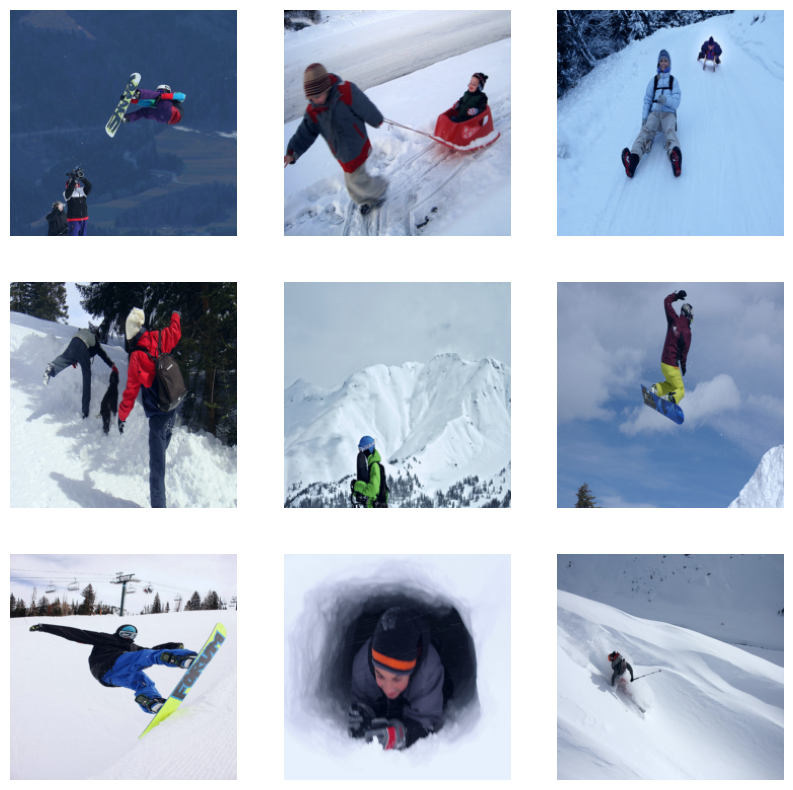

In [40]:
query = "winter sport"

find_matches(model, image_embeddings, query, val_dataset, n=9)